In [2]:
import pandas as pd

df = pd.read_csv("spotify.csv")
df.shape

(6468, 21)

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}

 Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

 alternative       1.00      0.99      0.99        71
     ambient       0.99      1.00      1.00       177
       chill       1.00      1.00      1.00       189
     dubstep       1.00      1.00      1.00       190
         edm       1.00      0.99      1.00       108
       house       0.99      1.00      1.00       101
       indie       1.00      0.99      1.00       131
         pop       0.98      0.99      0.99       132
         sad       0.99      0.99      0.99       195

    accuracy                           1.00      1294
   macro avg       1.00      1.00      1.00      1294
weighted avg       1.00      1.00      1.00      1294



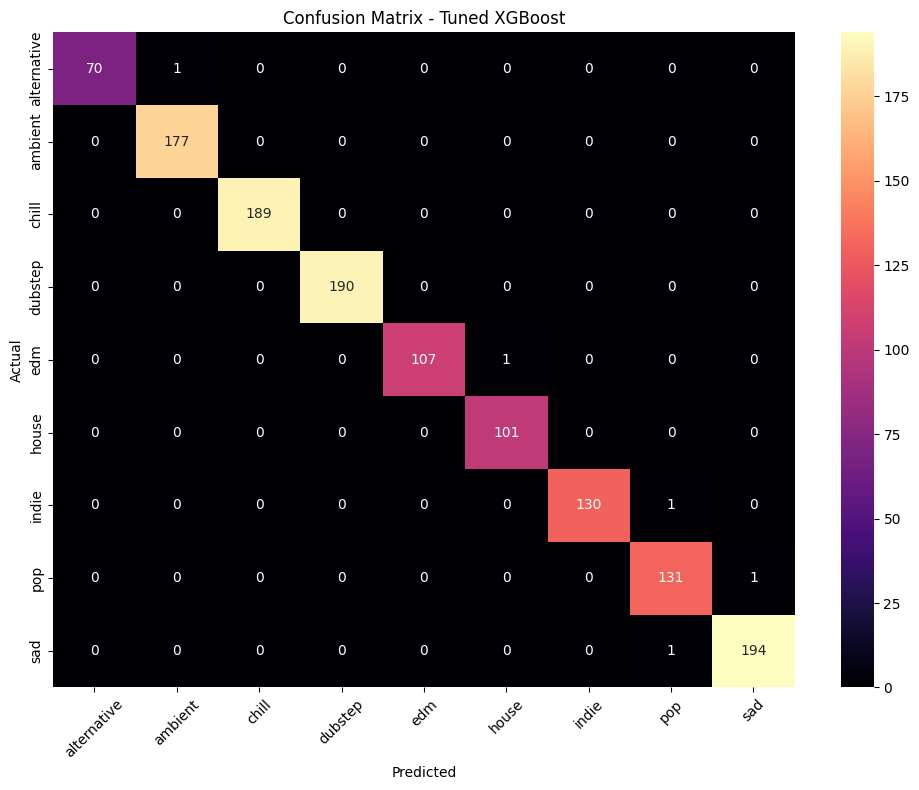

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

le_genre = LabelEncoder()
y_genre = le_genre.fit_transform(df['track_genre'])

X = df.drop(columns=['track_id', 'artists', 'album_name', 'track_name', 'track_genre'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_genre, test_size=0.2, stratify=y_genre, random_state=42
)

xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le_genre.classes_),
    eval_metric='mlogloss',
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=3,
                           verbose=0,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n Classification Report (Tuned XGBoost):")
print(classification_report(y_test, y_pred, target_names=le_genre.classes_))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma',
            xticklabels=le_genre.classes_,
            yticklabels=le_genre.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned XGBoost')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [3]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X_scaled, y_genre, cv=5, scoring='f1_weighted')
print(scores, scores.mean())

[0.89135153 1.         1.         1.         0.80584519] 0.9394393449241809


In [4]:
import numpy as np
y_shuffled = np.random.permutation(y_genre)
best_model.fit(X_scaled, y_shuffled)
y_fake_pred = best_model.predict(X_scaled)
print(classification_report(y_shuffled, y_fake_pred))

              precision    recall  f1-score   support

           0       0.95      0.70      0.80       358
           1       0.80      0.80      0.80       885
           2       0.80      0.86      0.83       945
           3       0.78      0.91      0.84       948
           4       0.95      0.79      0.86       538
           5       0.92      0.77      0.84       504
           6       0.91      0.83      0.87       653
           7       0.90      0.74      0.81       660
           8       0.75      0.91      0.82       977

    accuracy                           0.83      6468
   macro avg       0.86      0.81      0.83      6468
weighted avg       0.84      0.83      0.83      6468



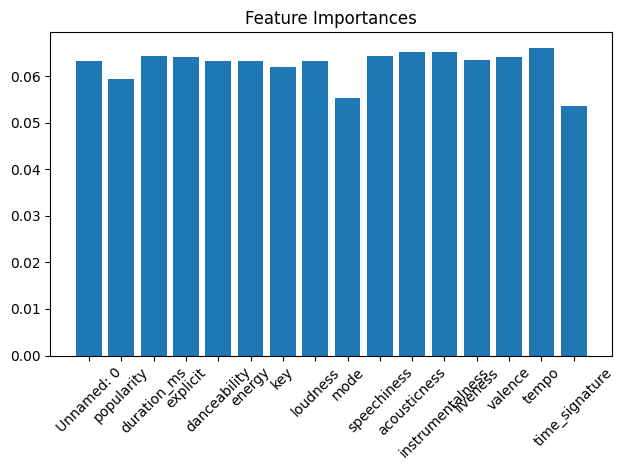

In [5]:
import matplotlib.pyplot as plt
importances = best_model.feature_importances_
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), X.columns, rotation=45)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()